# LLM辅助的计算社会科学分析实战

**版权声明：版权归属中山大学社会学系博士生贾梦真，为2023中山大学人工社会与计算社会科学讲习班学习资料，勿进行传播。**

## 一、微调模型


为什么要微调？       
- 教大模型适应个人独特究领域，学习新的知识，适应新目标任务。
- 大模型的训练可能会存在偏误。    

GPT-3模型被更强大的GPT-3.5所取代。然而，原始的GPT-3基本模型()是目前唯一可用于微调的模型。

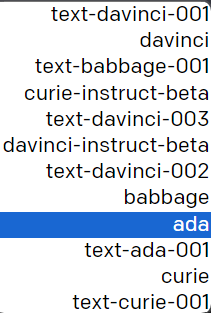

对大语言模型进行微调，帮助区分体育新闻中的棒球和曲棍球（sklearn包中的数据库fetch_20newsgroups）
数据连接[fetch_20newsgroups数据预览](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

[参考资料链接](https://github.com/openai/openai-cookbook/blob/c651bfdda64ac049747c2a174cde1c946e2baf1d/examples/Fine-tuned_classification.ipynb?short_path=60b8896)

### 1.1 准备数据和包

In [ ]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
#导入需要的包
from sklearn.datasets import fetch_20newsgroups #使用fetch_20newsgroups数据
import pandas as pd
import openai

In [ ]:
#将运动数据库中的训练集抽取出来，只选择棒球和曲棍球类别的。
categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

In [ ]:
#查看数据
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [ ]:
print(sports_dataset.target_names[sports_dataset['target'][0]])
print(sports_dataset.target_names[sports_dataset['target'][1]])
#标签0是棒球，标签1是曲棍球

rec.sport.baseball
rec.sport.hockey


In [ ]:
#看一下样本总数和两类球类的各自样本数
len_all = len(sports_dataset.data)
len_baseball = len([e for e in sports_dataset.target if e == 0])
len_hockey = len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


### 1.2 数据预处理

In [ ]:
import pandas as pd
#从数据集中提取标签信息
labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
#从数据集中提取文本信息
texts = [text.strip() for text in sports_dataset['data']]
#zip将标签和文本信息对应起来，然后指定为prompt和completion变量
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
#查看数据
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


In [ ]:
#将df格式的数据转换为jsonl数据，方便喂给大模型
df.to_json("sports2.jsonl",orient='records',lines=True)


### 1.3 数据准备工具

In [ ]:
import openai
openai.api_key="<自己的APIkey>"

In [ ]:
!openai tools fine_tunes.prepare_data -f /content/sports2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts e

- 这个对数据集提出了一些改进建议，并将数据集划分为训练集和验证集。
- 后缀`-q`用于告诉模型输入文本已经停止，现在需要预测类别。
- `classification_positive_class`告诉模型是用来预测`baseball`
- 还认识到这可能是一个分类任务，因此它建议将数据集分为训练和验证数据集。

### 1.4 微调模型

- 复制建议的命令。
- 添加了-m ada来微调更便宜、更快的ada模型，在分类上，它的性能通常与更慢、更昂贵的模型相当。




**多分类的写法**     
openai api fine_tunes.create \
  -t "TRAIN_FILE_ID_OR_PATH" \
  -v "VALIDATION_FILE_OR_PATH" \
  -m "MODEL" \
  --compute_classification_metrics \
  --classification_n_classes "NUMBER_OF_CLASSES"


**二分类的写法**    
openai api fine_tunes.create \
  -t "TRAIN_FILE_ID_OR_PATH" \
  -v "VALIDATION_FILE_OR_PATH" \
  -m "MODEL" \
  --compute_classification_metrics \
  --classification_n_classes 2 \
  --classification_positive_class "POSITIVE_CLASS_FROM_DATASET"



In [ ]:
!openai api fine_tunes.create -t "/content/sports2_prepared_train.jsonl" -v "/content/sports2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

Found potentially duplicated files with name 'sports2_prepared_train.jsonl', purpose 'fine-tune' and size 1519036 bytes
file-NelWQm9ndZmC2XbozmIOysDQ
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 

这里需要一些时间，可能还需要排队，等待时查看进度，复制fine tune名称，用于以后导出结果数据

In [ ]:
!openai api fine_tunes.list
#使用这句命令可以看微调进度

### 1.5 模型表现

In [ ]:
!openai api fine_tunes.results -i ft-tHOGDK2IyfTfFR7kbh3N1Ees > result.csv
#将微调的结果保存为result文件

In [ ]:
#读取result数据查看结果，查看模型表现：例如分类准确率、召回率、ROC等
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3721,3722,1693298,3722,0.015429,1.0,1.0,NaN,NaN,NaN,0.983193,0.97541,0.991667,0.999364,0.999391,0.983471


<Axes: >

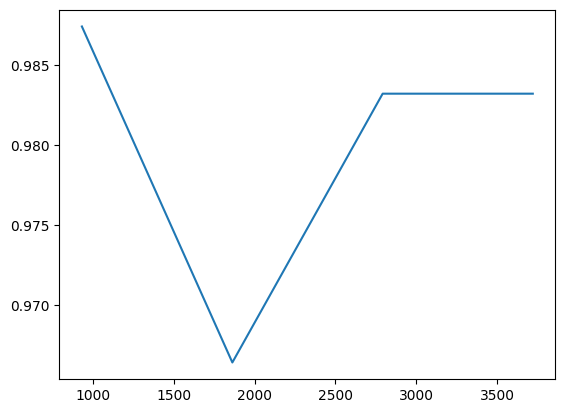

In [ ]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

可以看到在训练运行期间验证集的准确性是如何增加的。

### 1.6 使用模型


In [ ]:
#从原数据中抽取一部分得到一个小小的测试集
test= df.sample(frac=0.3, random_state=42)
print(test)
json_filename = "test_data.json"
test = df.to_json(json_filename, orient="records")

                                                prompt completion
921  From: dtate+@pitt.edu (David M. Tate)\nSubject...   baseball
321  From: golchowy@alchemy.chem.utoronto.ca (Geral...     hockey
101  From: kenney@tribe.b17d.ingr.COM (David Kenney...   baseball
920  From: cmk@athena.mit.edu (Charles M Kozierok)\...   baseball
58   From: filinuk@staff.dccs.upenn.edu (Geoff Fili...     hockey
..                                                 ...        ...
47   From: rsmith@strobe.ATC.Olivetti.Com (Russ Smi...   baseball
318  From: kbanaian@bernard.pitzer.claremont.edu (K...   baseball
106  From: ayim@leibniz.uwaterloo.ca (Alfred Yim)\n...     hockey
793  From: maynard@ramsey.cs.laurentian.ca (Roger M...     hockey
55   From: ccox@math.nwu.edu (Christopher L. Cox)\n...   baseball

[359 rows x 2 columns]




我们需要在提示符后面使用与微调期间使用的相同的分隔符。在这种情况下，它是\n\n###\n\n。由于我们关注的是分类，所以我们希望temperature尽可能低，并且我们只需要一个token完成来确定模型的预测。

In [ ]:

test = pd.read_json('test_data.json')
test.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


In [ ]:
ft_model = 'ada:ft-personal-2023-08-14-06-38-15' #输入微调后的模型名
openai.api_key="<自己的APIkey>"
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7c879c484130> JSON: {
  " hockey": -10.444916,
  " baseball": -5.7057543e-05
}

### 1.7 模型泛化


In [ ]:
sample_hockey_tweet = """Thank you to the
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [ ]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'

In [ ]:
#自己找个新闻test一下模型准确性：https://archive.seattletimes.com/archive/?date=19980201&slug=2731989
sample_twitter="""
GARMISCH-PARTENKIRCHEN, Germany - Austria's Andreas Schifferer won his fourth World Cup downhill of the season, establishing himself as the gold medal favorite for the Olympics.
"Sure, the win gives me confidence and I'm in good form," Schifferer said of his chances at Nagano. "But form doesn't count, a medal does."
Schifferer finished in 1 minute, 54.82 seconds."""
res = openai.Completion.create(model=ft_model, prompt=sample_twitter + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

### 附加案例：使用多分类数据

In [3]:
#使用一个新数据
#!pip install openai
import openai
import pandas as pd
####如果网络问题导致本地失败的话，在colab使用环境变量的设置方法；
import os
#os.environ['OPENAI_API_KEY'] = "<你的api>"
#print(os.getenv('OPENAI_API_KEY'))
#####如果本地网络可以用，就在本地使用API_key调用方法。
#openai.api_key="<你的key>...."
df=pd.read_csv("apple_tw.csv")
new_column_names = {
    "text": "prompt",
    "sentiment": "completion"
}
df.rename(columns=new_column_names, inplace=True)
df.head()
df.to_json("sentiment.jsonl",orient='records',lines=True)

In [ ]:
#"/content/sentiment.jsonl"改为自己的文件路径
!openai tools fine_tunes.prepare_data -f /content/sentiment.jsonl -q

Analyzing...

- Your file contains 1630 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 6 duplicated prompt-completion sets. These are rows: [412, 824, 1253, 1255, 1580, 1609]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tok

In [ ]:
#"/content/sentiment_prepared_train.jsonl" 改成自己的路径
!openai api fine_tunes.create -t "/content/sentiment_prepared_train.jsonl" -v "/content/sentiment_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 3 -m ada

Upload progress: 100% 183k/183k [00:00<00:00, 81.6Mit/s]
Uploaded file from /content/sentiment_prepared_train.jsonl: file-XQWvqdoEcC9I8m6LkC6hW51P
Upload progress: 100% 45.5k/45.5k [00:00<00:00, 67.0Mit/s]
Uploaded file from /content/sentiment_prepared_valid.jsonl: file-8iE4kO67VPm61wMQpKXLh0EU
Created fine-tune: ft-dOQm0t9tn09Da2NBW44htBDf
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-08-14 07:29:56] Created fine-tune: ft-dOQm0t9tn09Da2NBW44htBDf
[2023-08-14 07:30:08] Fine-tune costs $0.07
[2023-08-14 07:30:08] Fine-tune enqueued. Queue number: 0
[2023-08-14 07:30:09] Fine-tune started



In [ ]:
!openai api fine_tunes.list

{
  "object": "list",
  "data": [
    {
      "object": "fine-tune",
      "id": "ft-tHOGDK2IyfTfFR7kbh3N1Ees",
      "hyperparams": {
        "n_epochs": 4,
        "batch_size": 1,
        "prompt_loss_weight": 0.01,
        "learning_rate_multiplier": 0.1,
        "classification_positive_class": " baseball",
        "compute_classification_metrics": true
      },
      "organization_id": "org-KDFf6tjN5kzCVBvOIphbbvtG",
      "model": "ada",
      "training_files": [
        {
          "object": "file",
          "id": "file-NelWQm9ndZmC2XbozmIOysDQ",
          "purpose": "fine-tune",
          "filename": "/content/sports2_prepared_train.jsonl",
          "bytes": 1519036,
          "created_at": 1691992735,
          "status": "processed",
          "status_details": null
        }
      ],
      "validation_files": [
        {
          "object": "file",
          "id": "file-GKl2D4xMLWcjnW49cDPldRsJ",
          "purpose": "fine-tune",
          "filename": "/content/sports2_pre

In [ ]:
#ft-dOQm0t9tn09Da2NBW44htBDf替换成为自己的结果
!openai api fine_tunes.results -i ft-dOQm0t9tn09Da2NBW44htBDf > result.csv

<Axes: >

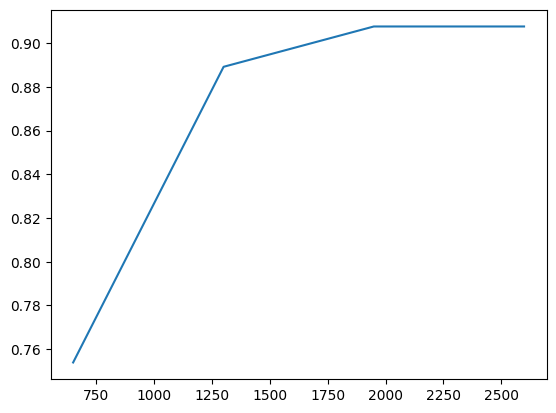

In [ ]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## 二、归纳范式：辅助分析聚类结果

参考链接：[link](https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb)

In [6]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval
# load data
datafile_path = "/content/fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)
# 字符串转换为numpy数组
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
matrix.shape

(1000, 1536)

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### 1. 使用kmeans聚类

In [8]:
from sklearn.cluster import KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
# 提取每个样本所属的簇标签，将簇标签添加到数据框中，作为一列
labels = kmeans.labels_
df["Cluster"] = labels
#对每个簇内的数据进行分组，计算分组内 "Score" 列的平均值，并按平均值排序，输出每个簇的平均分数，按照升序排列
df.groupby("Cluster").Score.mean().sort_values()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    4.105691
1    4.191176
2    4.215613
3    4.306590
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

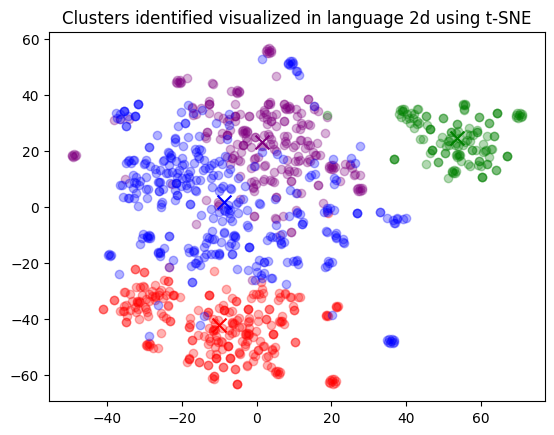

In [9]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]
# 对给定的数据矩阵进行降维，得到2维的可视化数据
for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

二维投影cluster。绿色集群cluster1 似乎与其他集群大不相同，跑完这步可以看看每个集群中一些样本。

### 2. 使用chatgpt对聚类结果进行总结

In [11]:
openai.api_key="<自己的api>"

In [25]:
import openai
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
) #导入重试包，防止因为单词引用超出速率限制导致报错

# 逐个聚类簇循环
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
    #使用指数随机等待策略来控制重试间隔，重试10次
    def retry_generate_theme():
        # 从当前簇内的数据中选取一些评价
        reviews = "\n".join(
            df[df.Cluster == i]
            .combined.str.replace("Title: ", "")
            .str.replace("\n\nContent: ", ":  ")
            .sample(rev_per_cluster, random_state=42)
            .values
        )
        # 使用 OpenAI 的模型生成与选取的评价共同特点相关的主题描述
        response = openai.Completion.create(
            engine="ada",
            prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
            temperature=0,
            max_tokens=40,
            #设定单次输出的token限制，以避免因为速率限制报错。
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
        return response["choices"][0]["text"].replace("\n", "")

    theme = retry_generate_theme()
    print(theme)

    # 从当前簇内的数据中选取一些样本评价并打印它们的分数、摘要和部分内容
    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)  # 打印分隔线


Cluster 0 Theme: The theme is a combination of the following:The theme is a combination of the following:The theme is a combination of the following:The theme is a combination
5, Loved these gluten free healthy bars, saved $$ ordering on Amazon:   These Kind Bars are so good and healthy & gluten free.  My daughter ca
1, Should advertise coconut as an ingredient more prominently:   First, these should be called Mac - Coconut bars, as Coconut is the #2
5, very good!!:   just like the runts<br />great flavor, def worth getting<br />I even o
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: "I'm a big fan of Merrick's cat food. I've tried a few brands and this is the best. I've tried a few different brands and this is the best.
2, Messy and apparently undelicious:   My cat is not a huge fan. Sure, she'll lap up the gravy, but leaves th
4, The cats like it:   My 7 cats like this food but it is a little yucky for the human. 


- 这个聚类先将相似的文本经过向量化处理进行聚类，将相似的文本聚到一组，然后让大语言模型总结每个类别的文本内容（数据预先经过embedding处理）。提供了llm对无监督机器学习结果进行加工和深入分析的一个启发；
- 大模型的聚类结果是否符合文本本身的含义，还需要人工把关；
- prompt可以继续优化，提出更好分类；
- 可以使用聚类的标准+大语言模型+人工共同优化无监督学习结果；
- 参考这种避免速率限制报错的代码写法。






## 三、生成范式：生成智能体

- [开源代码链接:](https://github.com/joonspk-research/generative_agents)
- [项目demo链接：](https://reverie.herokuapp.com/arXiv_Demo/)

# 总结：
大语言模型为计算社会科学带来什么？
**基于社会科学研究范式的改进**
- 在归纳范式上，辅助计算社会科学进行因果探索；
- 在演绎范式上，辅助计算科学的ABM分析，提供更稳健的对人类社会的模拟。

- 机器学习中：     
1. 在有监督机器学习过程中，辅助人类打标签；
2. 在无监督机器学习中，LLM辅助计算社会科学的计算和解释。    
- 文本分析中：
1. 文本分类
2. 文本情感分析
3. 主题模型
4. 命名实体识别
5. ……

**但是需要注意：**
- 大语言模型作为通用语言模型需要与自己特有的模型、知识相结合，才有可能得到理想的结果。
- 使用大模型时，必须考虑和验证大模型结果的稳健性，不可迷信大模型。
- 大模型有固有的缺陷。
